# Forecasting Web Traffic in Wikipedia pages

##### "This competition focuses on the problem of forecasting the future values of multiple time series, as it has always been one of the most challenging problems in the field. More specifically, we aim the competition at testing state-of-the-art methods designed by the participants, on the problem of forecasting future web traffic for approximately 145,000 Wikipedia articles."

"The training dataset consists of approximately 145k time series. Each of these time series represent a number of daily views of a different Wikipedia article, starting from July, 1st, 2015 up until December 31st, 2016. The leaderboard during the training stage is based on traffic from January, 1st, 2017 up until March 1st, 2017.

The second stage will use training data up until September 1st, 2017. The final ranking of the competition will be based on predictions of daily views between September 13th, 2017 and November 13th, 2017 for each article in the dataset. You will submit your forecasts for these dates by September 12th.

For each time series, you are provided the name of the article as well as the type of traffic that this time series represent (all, mobile, desktop, spider). You may use this metadata and any other publicly available data to make predictions. Unfortunately, the data source for this dataset does not distinguish between traffic values of zero and missing values. A missing value may mean the traffic was zero or that the data is not available for that day.

To reduce the submission file size, each page and date combination has been given a shorter Id. The mapping between page names and the submission Id is given in the key files."

Source: https://www.kaggle.com/c/web-traffic-time-series-forecasting/data

First, we'll just load basic packages.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
%matplotlib inline

# For marchine Learning Approach
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from datetime import timedelta

NaN values will be filled with 0 since the dataset does not distinguish between 0 and missing.

# 4.2.2 Understanding the dataset 

In [3]:
train = pd.read_csv('input/train_1.csv').fillna(0) # Loading data
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [4]:
import math
import os
for f in os.listdir('input/'):
    size_bytes = round(os.path.getsize('input/' + f)/ 1000, 2)
    size_name = ["KB", "MB"]
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    print(f.ljust(25) + str(s).ljust(7) + size_name[i])

key_1.csv                727.99 MB
key_2.csv                752.26 MB
train_1.csv              271.5  MB
train_2.csv              397.43 MB


To save some memoryfrom 600 Mbyte to 300 Mbyte we can downcast the data into integer format. 

In [5]:
# Commented out for now to stop errors with some of the statsmodels methods
for col in train.columns[1:]:
    train[col] = pd.to_numeric(train[col],downcast='integer')
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,...,32,63,15,26,14,20,22,19,18,20
1,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,22,11,10,...,17,42,28,15,9,30,52,45,26,20
2,3C_zh.wikipedia.org_all-access_spider,1,0,1,1,0,4,0,3,4,...,3,1,1,7,4,4,6,3,4,17
3,4minute_zh.wikipedia.org_all-access_spider,35,13,10,94,4,26,14,9,11,...,32,10,26,27,16,11,17,19,10,11
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0,0,0,0,0,0,0,0,0,...,48,9,25,13,3,11,27,13,36,10


### Next we will take a look at the distribution of wikipedia pages that are contained in the domain of wikipedia.org vs the rest. Other pages are wikipedia pages in other languages than English.

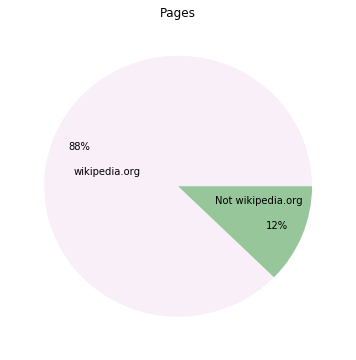

In [6]:
pages = pd.read_csv('input/train_1.csv',usecols=['Page'],squeeze=True)
# current_palette = sns.color_palette()
pal = sns.cubehelix_palette(1, start=2, rot=-10, dark=.7, light=.95,as_cmap=True)

#plot dist
labels = ['wikipedia.org','Not wikipedia.org']
fig,ax = plt.subplots(1,figsize=(6,6))
(pages.str.lower().str.contains('wikipedia.org').value_counts().rename(
    index=lambda x: ['Not wikipedia.org','wikipedia.org'] )/len(pages)).plot(
    kind='pie',labels=labels,autopct='%1.0f%%', pctdistance=.8, labeldistance=.3,ax=ax,cmap=pal);
ax.set_title('Pages');
ax.set_ylabel('');

#### Structural changes and creating calculating the median & average by page 

In [7]:
train_flattened = pd.melt(train[list(train.columns[-50:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)
# Median by page
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']

# Average by page
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

# Merging data
train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median)

train_flattened.reset_index(drop=False,inplace=True)

train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())

# Feature engineering with the date
train_flattened['year']=train_flattened.date.dt.year 
train_flattened['month']=train_flattened.date.dt.month 
train_flattened['day']=train_flattened.date.dt.day

In [8]:
train_flattened.head()

,Page,date,Visits,weekend,mean,median,weekday,year,month,day
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2,1.0,2.78,2.0,5,2016,11,12
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2,1.0,2.78,2.0,6,2016,11,13
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4,0.0,2.78,2.0,0,2016,11,14
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8,0.0,2.78,2.0,1,2016,11,15
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3,0.0,2.78,2.0,2,2016,11,16


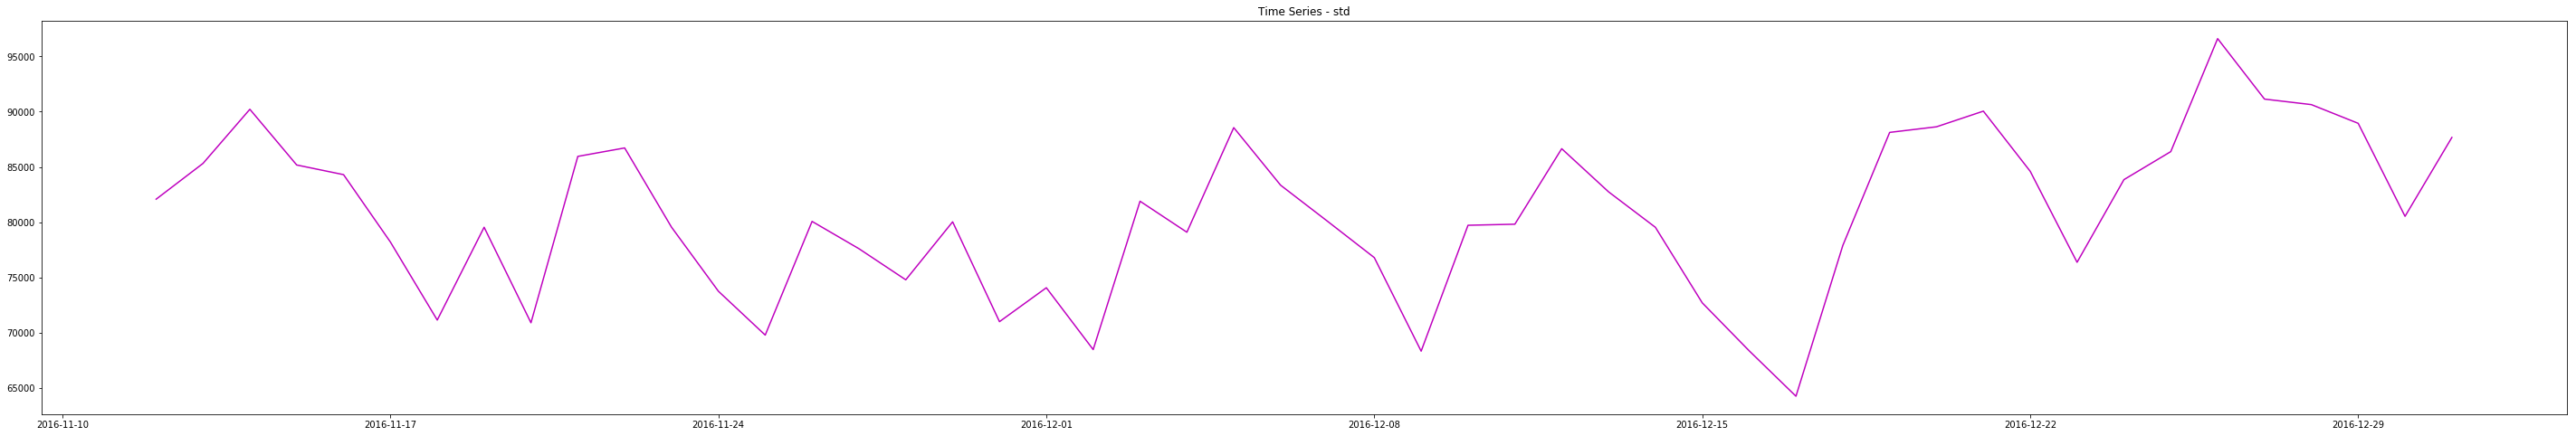

In [9]:
plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].std()
plt.plot(std_group, color = 'm')
plt.title('Time Series - std')
plt.show()

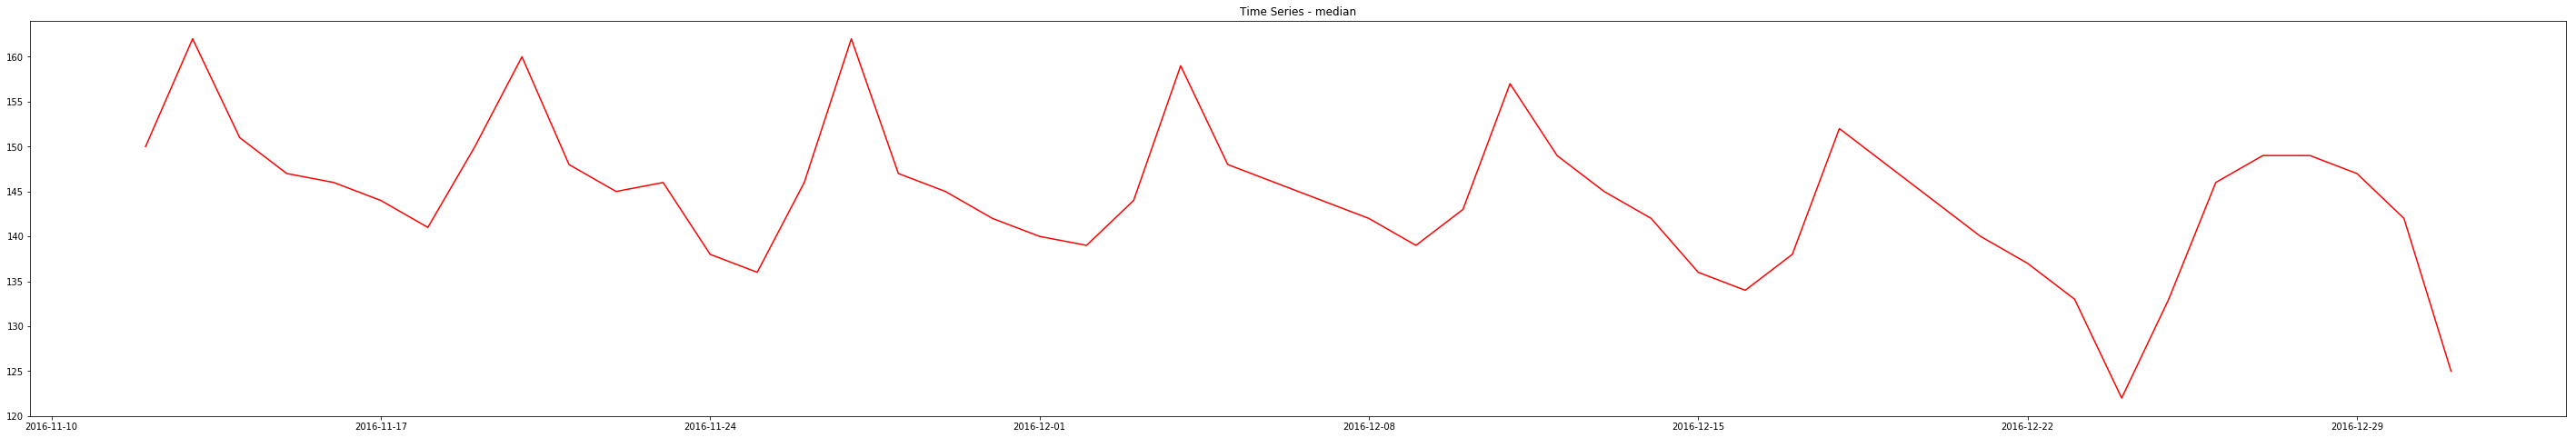

In [11]:
plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].median()
plt.plot(std_group, color = 'r')
plt.title('Time Series - median')
plt.show()

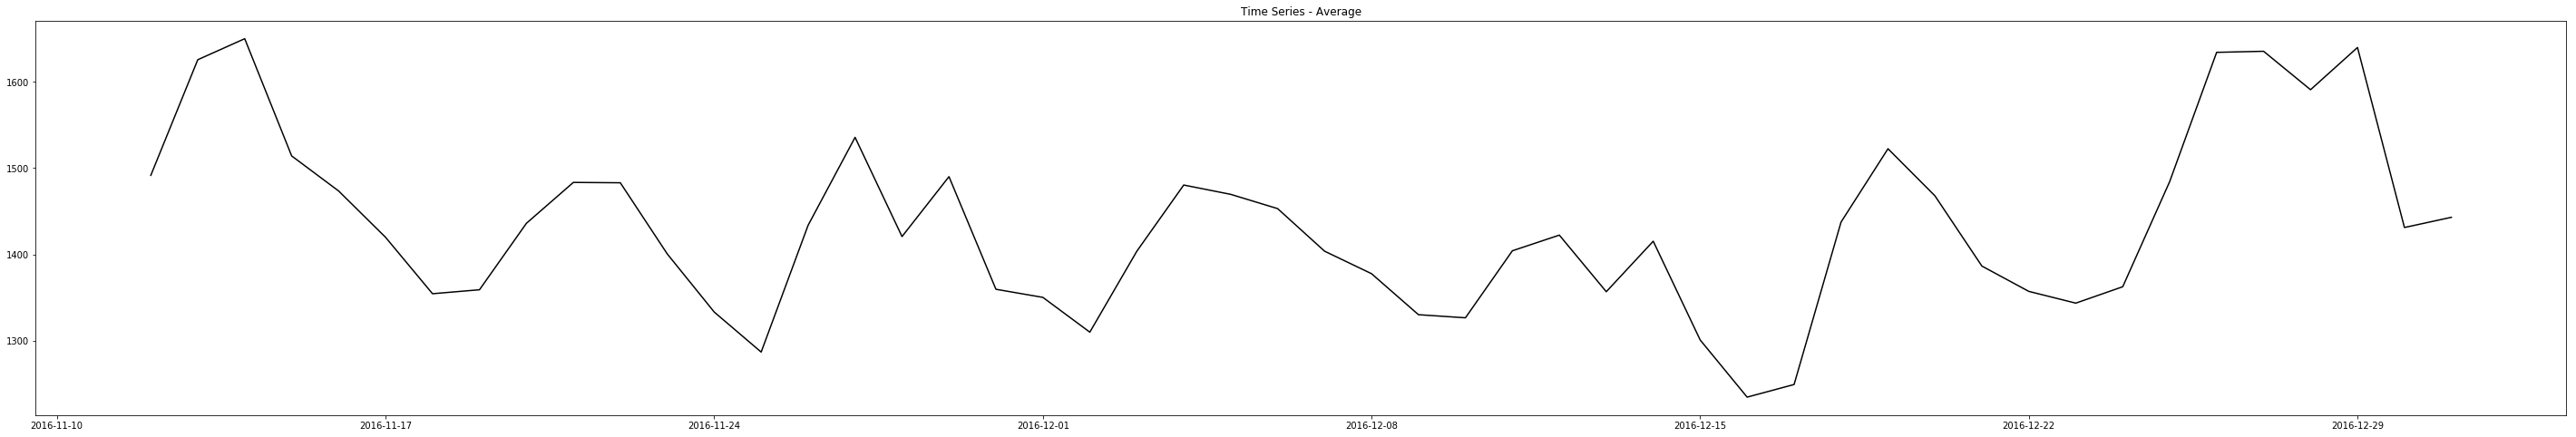

In [12]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group, color='k')
plt.title('Time Series - Average')
plt.show()

# 4.2.3 Preprocessing and time-domain features

### Can we predict traffic based on language?


In [15]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

train['lang'] = train.Page.map(get_language)

from collections import Counter

print(Counter(train.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


There are 7 languages plus the media pages. The languages used here are: English, Japanese, German, French, Chinese, Russian, and Spanish. 

In [16]:
lang_sets = {}
lang_sets['en'] = train[train.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train[train.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train[train.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train[train.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train[train.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train[train.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train[train.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train[train.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

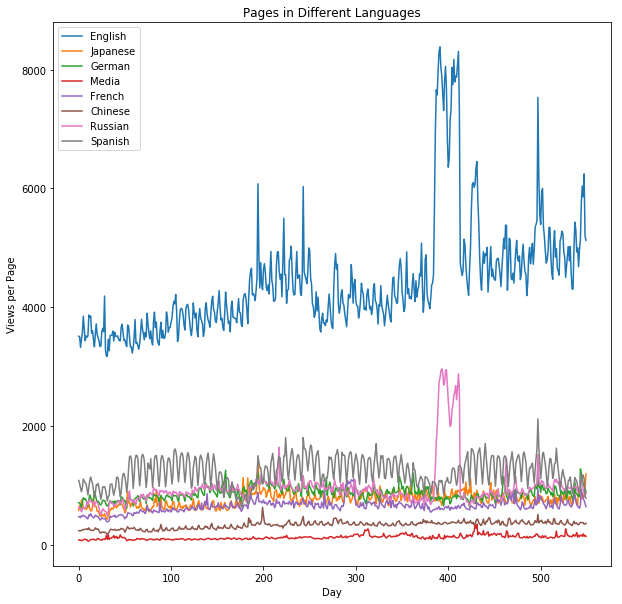

In [17]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()


The Summer olympics in August and elections of US show high spikes for English and Russian.








# Individual Entry Data

Now, I'll plot the data for some individual entries. I've picked some entries to look at, but there's not necessarily anything special about them.

In [26]:
def plot_entry(key,idx):
    data = lang_sets[key].iloc[idx,1:]
    fig = plt.figure(1,figsize=(10,5))
    plt.plot(days,data)
    plt.xlabel('day')
    plt.ylabel('views')
    plt.title(train.iloc[lang_sets[key].index[idx],0])
    
    plt.show()

First, let's look at some English pages.

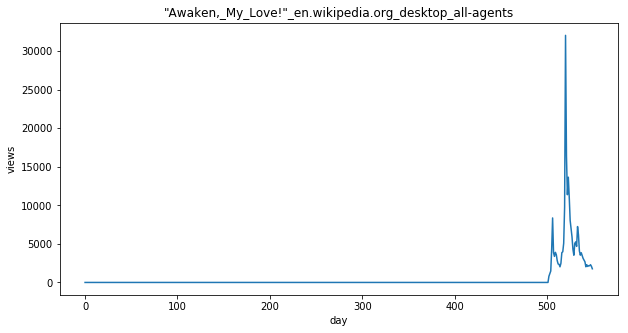

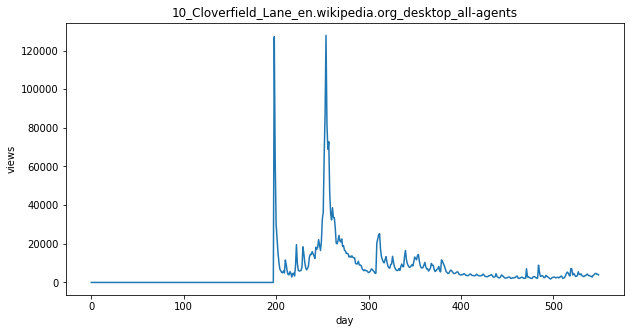

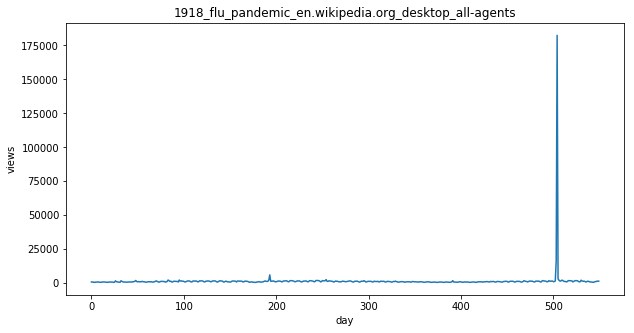

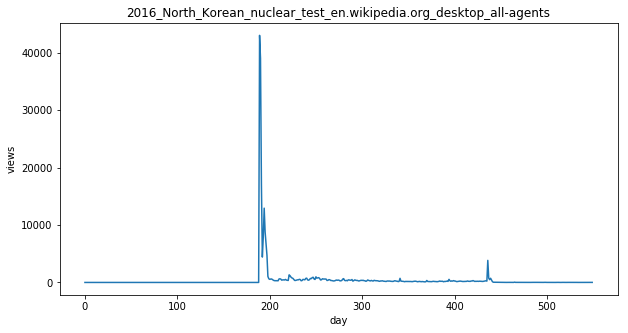

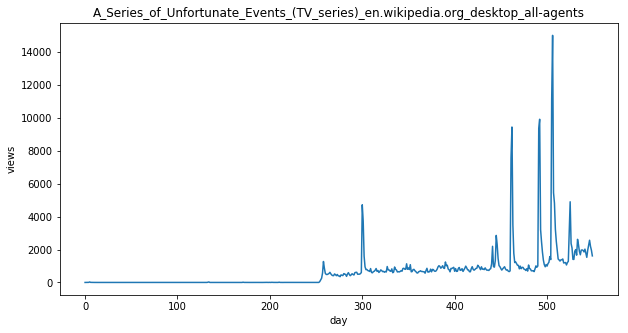

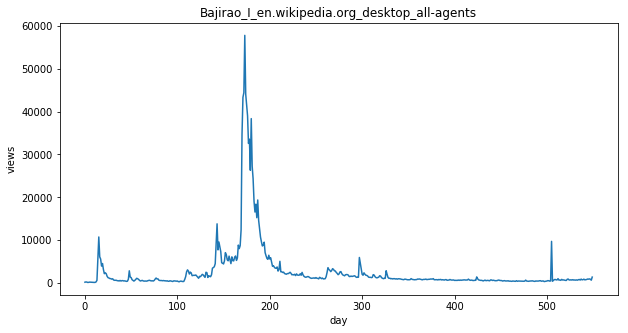

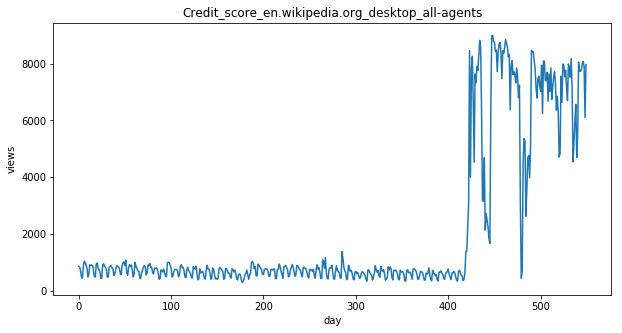

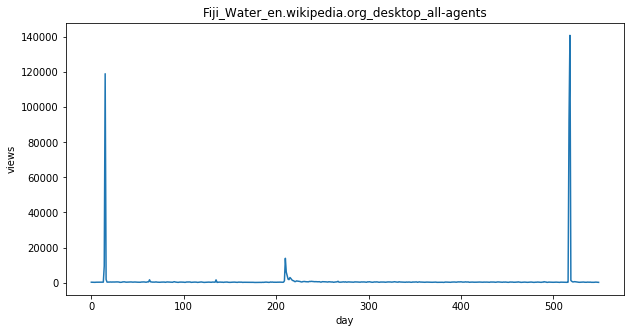

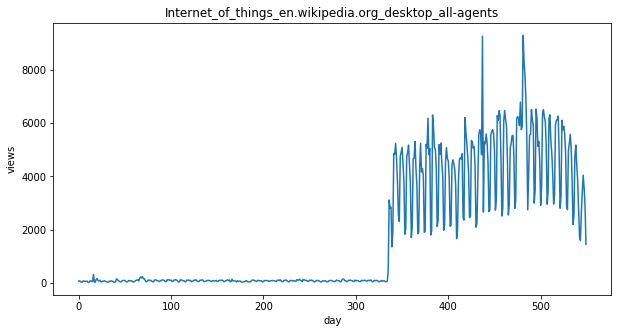

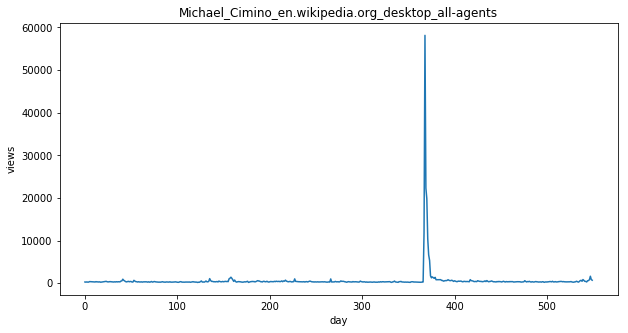

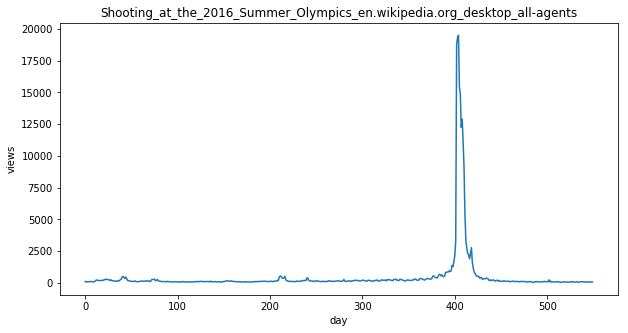

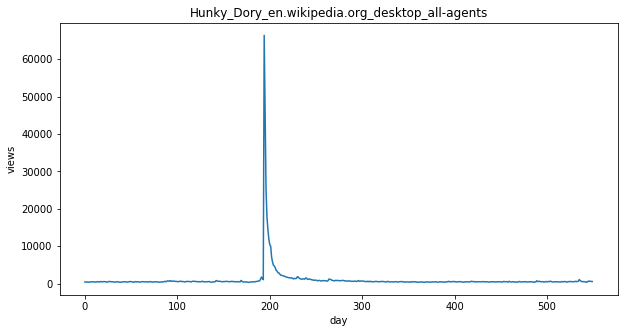

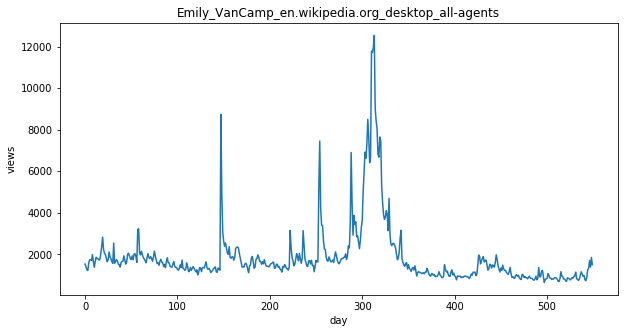

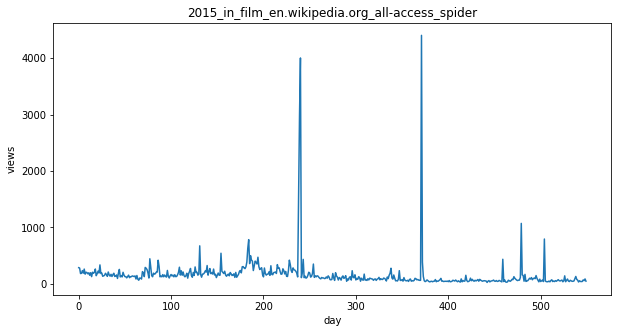

In [19]:
idx = [1, 5, 10, 50, 100, 250,500, 750,1000,1500,2000,3000,4000,5000]
for i in idx:
    plot_entry('en',i)


# How does the aggregated data compare to the most popular pages?


In [30]:
# For each language get highest few pages
npages = 5
top_pages = {}
for key in lang_sets:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values('total',ascending=False)
    print(sum_set.head(10))
    top_pages[key] = sum_set.index[0]
    print('\n\n')

en
                                                    Page        total
38573   Main_Page_en.wikipedia.org_all-access_all-agents  12066181102
9774       Main_Page_en.wikipedia.org_desktop_all-agents   8774497458
74114   Main_Page_en.wikipedia.org_mobile-web_all-agents   3153984882
39180  Special:Search_en.wikipedia.org_all-access_all...   1304079353
10403  Special:Search_en.wikipedia.org_desktop_all-ag...   1011847748
74690  Special:Search_en.wikipedia.org_mobile-web_all...    292162839
39172  Special:Book_en.wikipedia.org_all-access_all-a...    133993144
10399   Special:Book_en.wikipedia.org_desktop_all-agents    133285908
33644       Main_Page_en.wikipedia.org_all-access_spider    129020407
34257  Special:Search_en.wikipedia.org_all-access_spider    124310206



ja
                                                     Page      total
120336      メインページ_ja.wikipedia.org_all-access_all-agents  210753795
86431          メインページ_ja.wikipedia.org_desktop_all-agents  134147415
123025       特

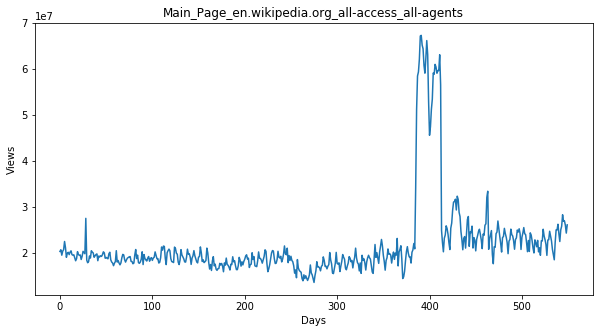

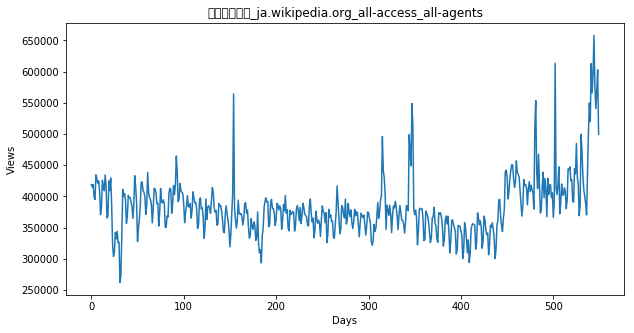

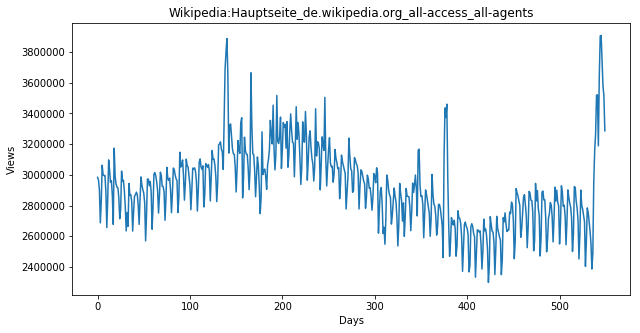

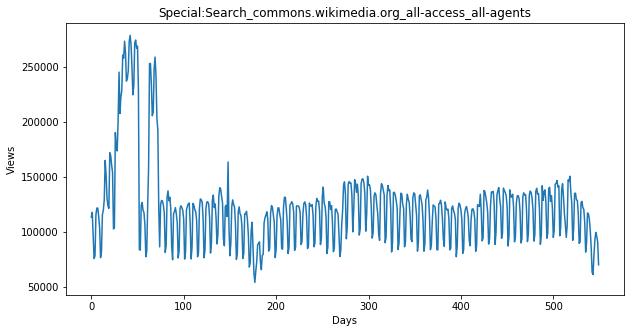

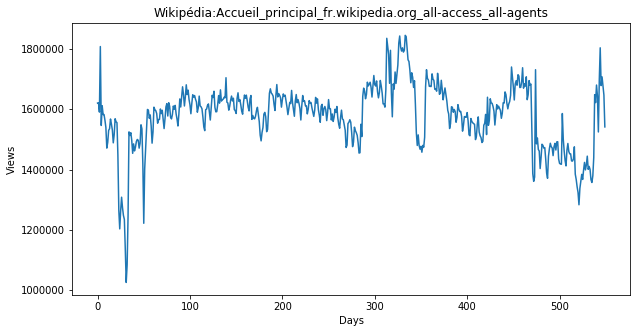

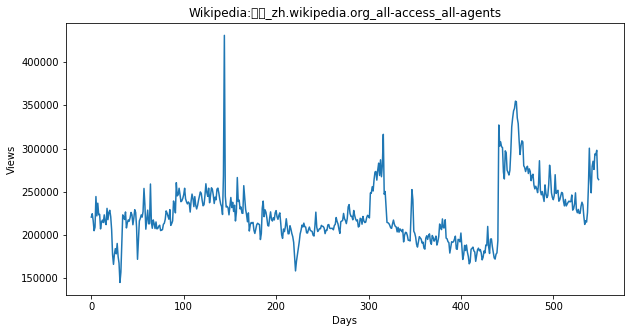

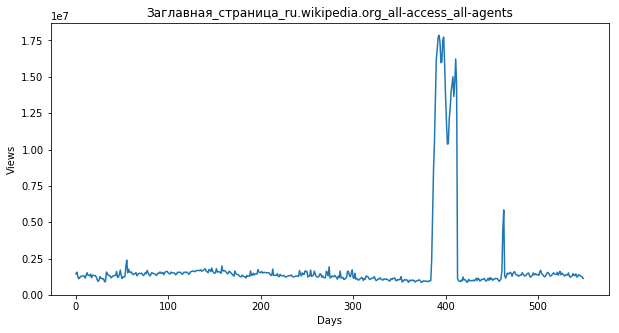

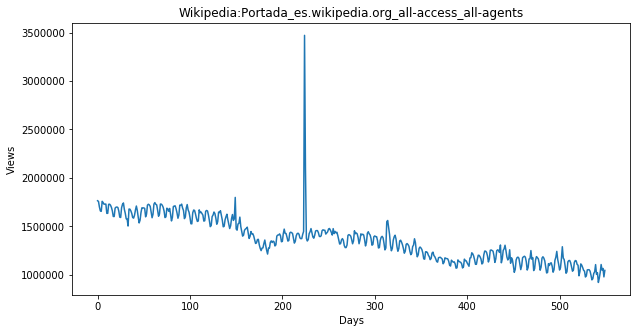

In [31]:
for key in top_pages:
    fig = plt.figure(1,figsize=(10,5))
    cols = train.columns
    cols = cols[1:-1]
    data = train.loc[top_pages[key],cols]
    plt.plot(days,data)
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.title(train.loc[top_pages[key],'Page'])
    plt.show()

Comparing these to the aggregated data, we see that things are mostly pretty similar. I'm actually quite surprised that the Olympics would have such a huge effect on a site like Wikipedia. I would say that the Japanese, Spanish, and media data differ the most. For media pages, this is expected since most people will access pages via links from other sites rather than through the main page or search function. The fact that some of the languages show large differences between the main page and the aggregated data suggests that the dataset is perhaps not very representative of all traffic to Wikipedia.

# More Analysis 
## Peak Detection



In [35]:
%%capture
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
import peakutils


for key in top_pages:
    fig = plt.figure(1,figsize=[10,5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    cols = train.columns[1:-1]
    data = np.array(train.loc[top_pages[key],cols])
    data_diff = [data[i] - data[i-1] for i in range(1,len(data))]
    autocorr = acf(data_diff)
    pac = pacf(data_diff)

    x = [x for x in range(len(pac))]
    ax1.plot(x[1:],autocorr[1:])

    ax2.plot(x[1:],pac[1:])
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Autocorrelation')
    ax1.set_title(train.loc[top_pages[key],'Page'])

    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Partial Autocorrelation')
    plt.show();

Detect peaks without any filters.
Peaks are: [ 3  9 16 23 31 37 39]


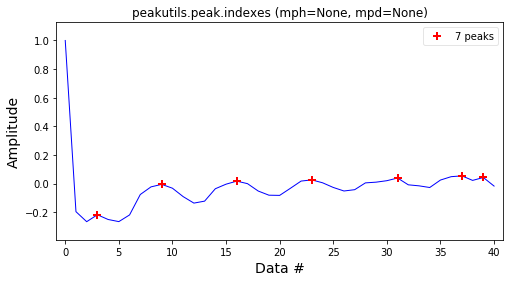

In [38]:
import peakutils.peak
from vector import vector, plot_peaks


print('Detect peaks without any filters.')
indexes = peakutils.peak.indexes(pac, thres=0, min_dist=0)
print('Peaks are: %s' % (indexes))
plot_peaks(
    pac,
    indexes,
    algorithm='peakutils.peak.indexes'
)

Detect peaks without any filters.
Peaks are: [ 7 14 21 28 35]


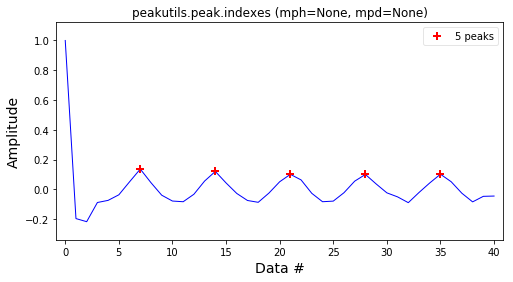

In [39]:
print('Detect peaks without any filters.')
indexes = peakutils.peak.indexes(autocorr, thres=0, min_dist=0)
print('Peaks are: %s' % (indexes))
plot_peaks(
    autocorr,
    indexes,
    algorithm='peakutils.peak.indexes'
)

Detect peaks without any filters.
Peaks are: [ 0  7 14 21 28 35 40]


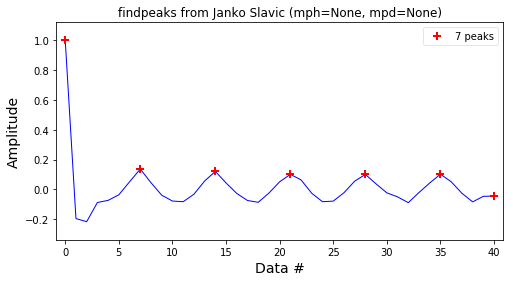

In [44]:
from libs import detect_peaks
import scipy.signal
from libs.findpeaks import findpeaks
print('Detect peaks without any filters.')
indexes = findpeaks(autocorr, spacing=2)
print('Peaks are: %s' % (indexes))
plot_peaks(
    autocorr,
    np.array(indexes),
    algorithm='findpeaks from Janko Slavic'
)

Detect peaks without any filters.
Peaks are: [ 0  3  9 16 23 31 37 39]


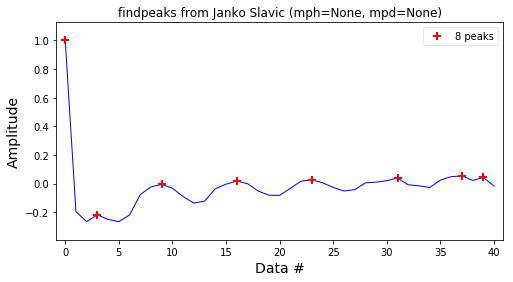

In [45]:
print('Detect peaks without any filters.')
indexes = findpeaks(pac, spacing=1)
print('Peaks are: %s' % (indexes))
plot_peaks(
    pac,
    np.array(indexes),
    algorithm='findpeaks from Janko Slavic'
)

Detect peaks without any filters.
Peaks are: [  0   5   8  13  21  28  34  42  48  50  55  62  68  75  78  84  89  91
  97 104 110 112 118 126 131 133 140 146 149 154 162 166 168 174 181 185
 188 190 197 202 209 217 224 231 237 244 246 251 255 257 259 265 272 278
 280 285 287 293 300 308 314 322 328 335 343 349 356 363 371 376 383 386
 390 397 405 412 419 426 433 436 441 446 448 455 462 469 471 475 482 488
 491 497 503 511 517 523 532 539 541 545 547 549]


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

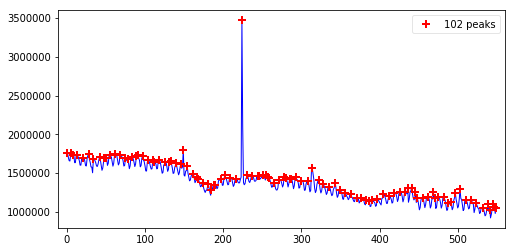

In [46]:
print('Detect peaks without any filters.')
indexes = findpeaks(data, spacing=1)
print('Peaks are: %s' % (indexes))
plot_peaks(
    data,
    np.array(indexes),
    algorithm='findpeaks from Janko Slavic'
)


Detect peaks without any filters.
Peaks are: [  0   5   8  13  21  28  34  42  48  50  55  62  68  75  78  84  89  91
  97 104 110 112 118 126 131 133 140 146 149 154 162 166 168 174 181 185
 188 190 197 202 209 217 224 231 237 244 246 251 255 257 259 265 272 278
 280 285 287 293 300 308 314 322 328 335 343 349 356 363 371 376 383 386
 390 397 405 412 419 426 433 436 441 446 448 455 462 469 471 475 482 488
 491 497 503 511 517 523 532 539 541 545 547 549]


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

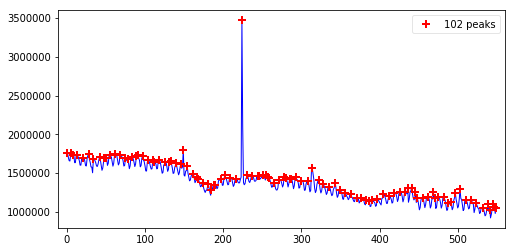

In [47]:
from libs.tony_beltramelli_detect_peaks import detect_peaks

print('Detect peaks without any filters.')
indexes = findpeaks(data, spacing=1)
print('Peaks are: %s' % (indexes))
plot_peaks(
    data,
    np.array(indexes),
    algorithm='findpeaks from Janko Slavic'
)

# 4.2.4 Frequency domain features
# Fast Fourier Transform (FFT)

Peaks in the FFT show us the strongest frequencies in the periodic signal.

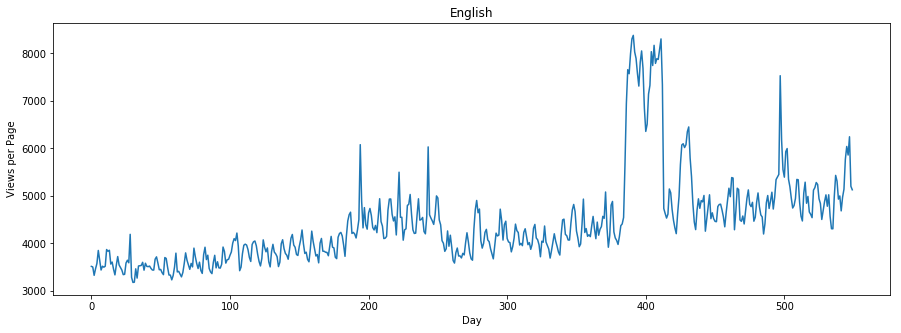

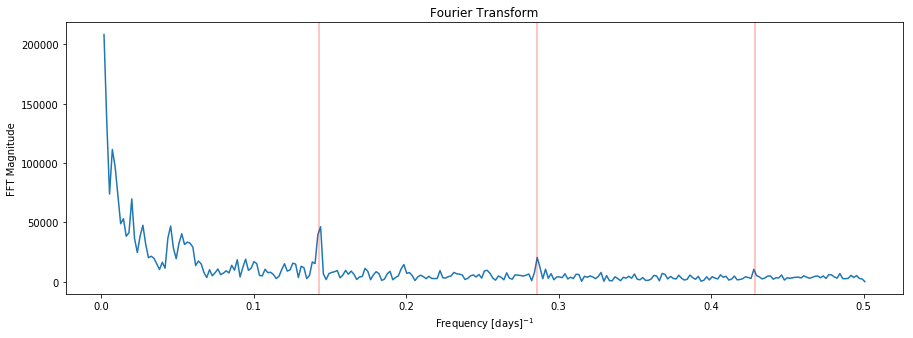

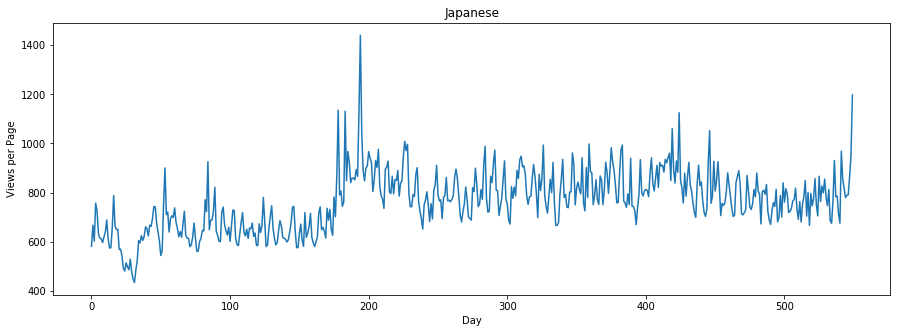

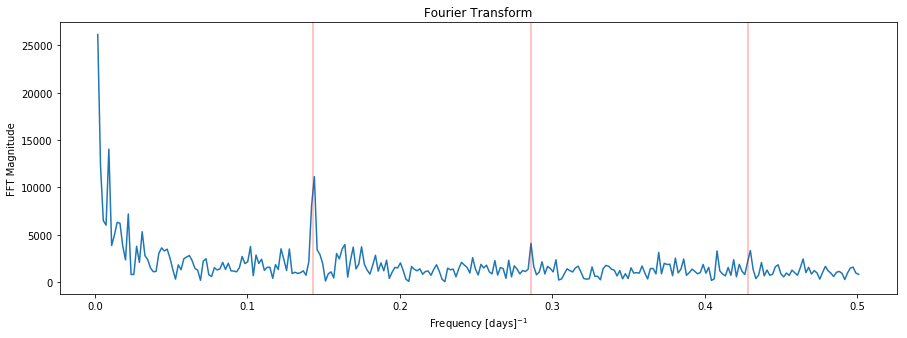

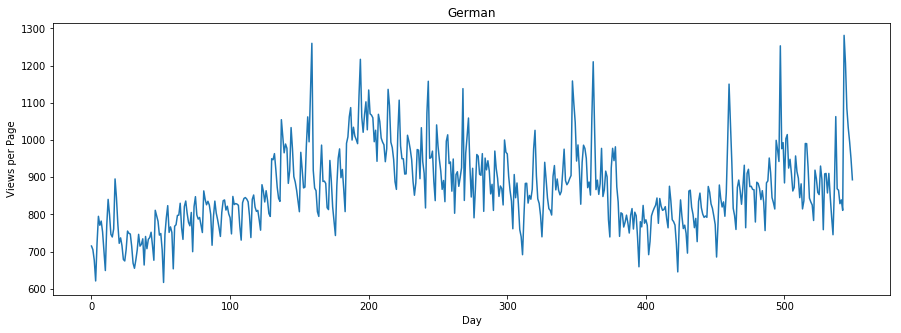

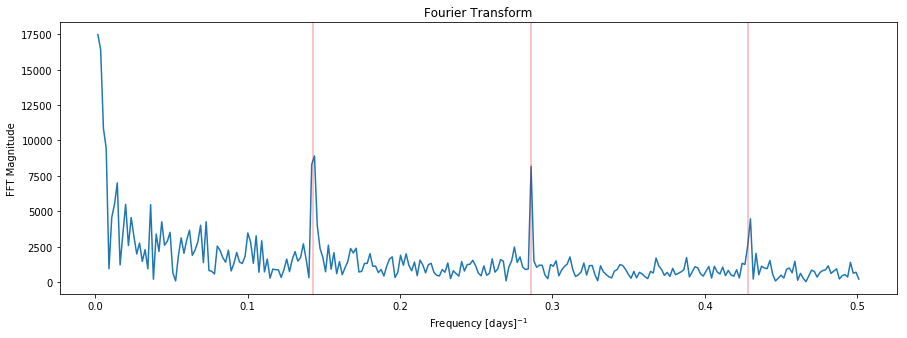

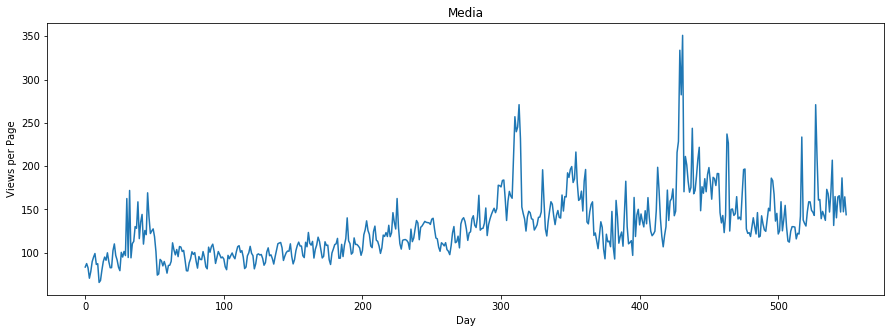

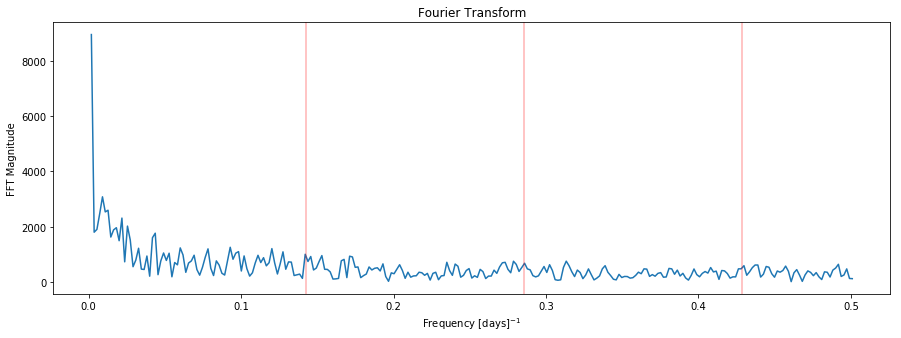

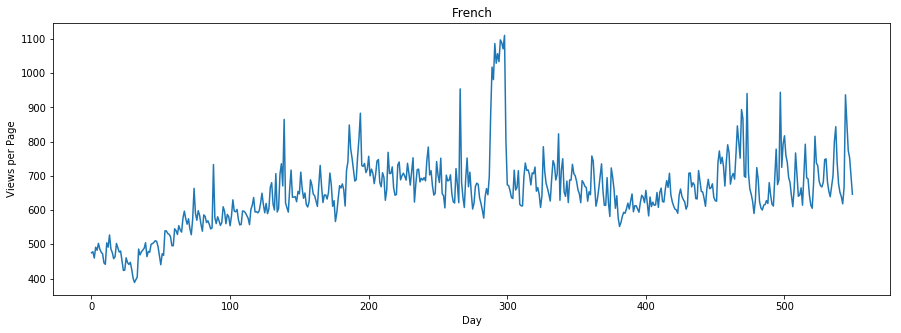

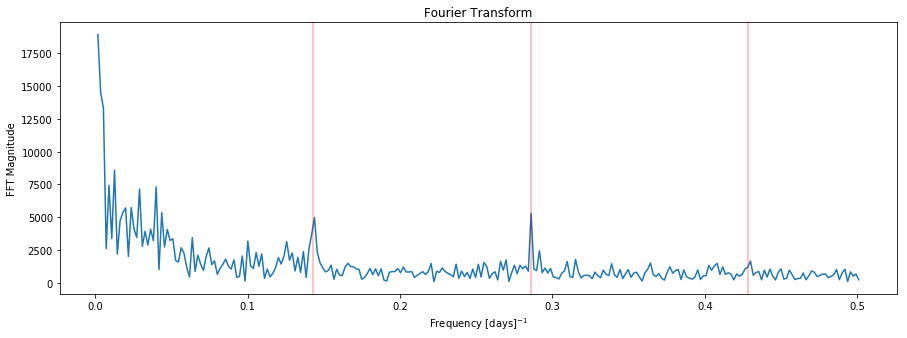

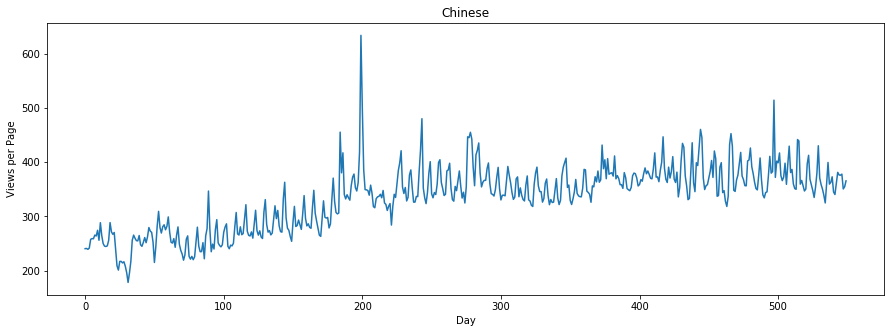

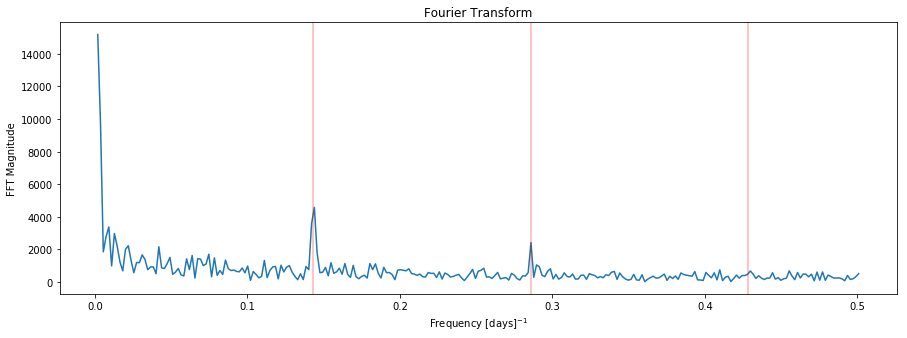

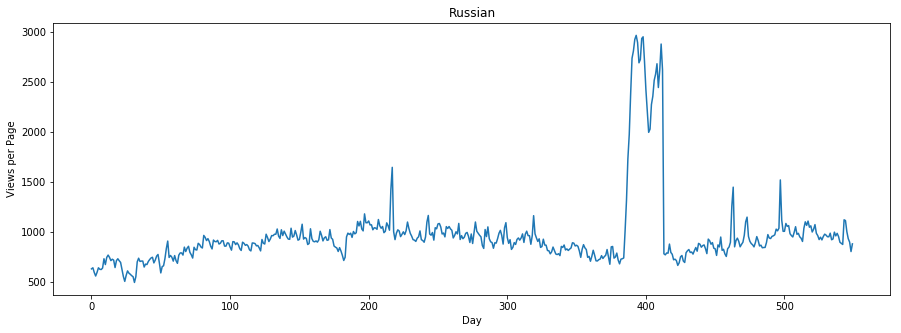

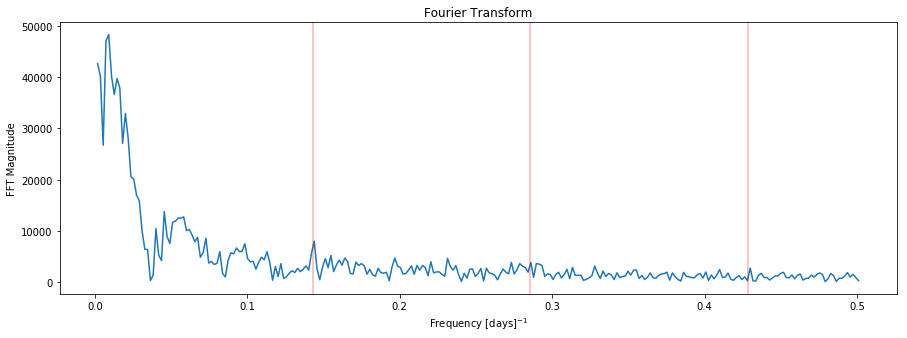

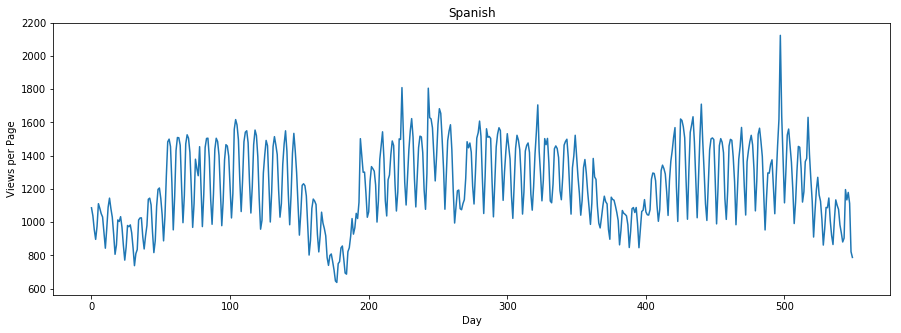

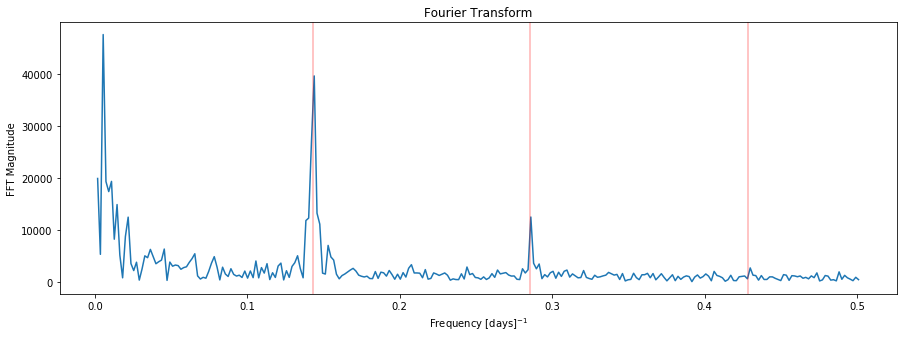

In [48]:
from scipy.fftpack import fft
def plot_with_fft(key):

    fig = plt.figure(1,figsize=[15,5])
    plt.ylabel('Views per Page')
    plt.xlabel('Day')
    plt.title(labels[key])
    plt.plot(days,sums[key],label = labels[key] )
    
    fig = plt.figure(2,figsize=[15,5])
    fft_complex = fft(sums[key])
    fft_mag = [np.sqrt(np.real(x)*np.real(x)+np.imag(x)*np.imag(x)) for x in fft_complex]
    fft_xvals = [day / days[-1] for day in days]
    npts = len(fft_xvals) // 2 + 1
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
        
    plt.ylabel('FFT Magnitude')
    plt.xlabel(r"Frequency [days]$^{-1}$")
    plt.title('Fourier Transform')
    plt.plot(fft_xvals[1:],fft_mag[1:],label = labels[key] )
    # Draw lines at 1, 1/2, and 1/3 week periods
    plt.axvline(x=1./7,color='red',alpha=0.3)
    plt.axvline(x=2./7,color='red',alpha=0.3)
    plt.axvline(x=3./7,color='red',alpha=0.3)

    plt.show()

for key in sums:
    plot_with_fft(key)

# 4.2.5 Dynamic Time Warping

In [1]:
class KnnDtw(object):

    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):

        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            p = ProgressBar(shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            p = ProgressBar(dm_size)
        
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)
        
            return dm
        
    def predict(self, x):

        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

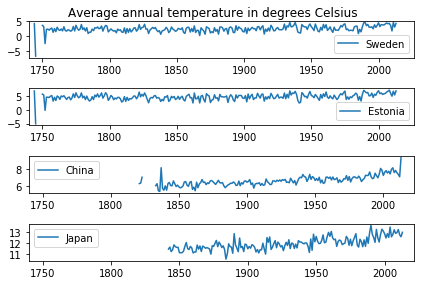

            Sweden  	 Estonia  	  China   	  Japan   	
Sweden        0     	   412    	   1030   	   2419   	
Estonia      412    	    0     	   278    	   1772   	
China        1030   	   278    	    0     	   964    	
Japan        2419   	   1772   	   964    	    0     	


In [5]:
import sys


global_temp = pd.read_csv('input/data.csv') # I changed the countries. It was very difficult to find a dataset to apply DTW to, so my focus was on learning the code 
# so I could understand it and help with this topic as a teaching assistant as well. 
global_temp['dt'] = pd.to_datetime(global_temp['dt'])
global_temp['year'] = global_temp['dt'].dt.year
global_temp.index = global_temp['dt'].values

countries = ['Sweden', 'Estonia', 'China', 'Japan']
yearly_temp = dict()
plt.figure()
for i, c in enumerate(countries):
    yearly_temp[c] = global_temp[global_temp['Country'] == c].resample('1Y').mean()
    yearly_temp[c].index = yearly_temp[c]['year'].values
    yearly_temp[c] = yearly_temp[c]['AverageTemperature']
    yearly_temp[c] = yearly_temp[c][1:]
    plt.subplot(4, 1, i+1)
    plt.plot(yearly_temp[c], label=c)
    plt.legend()
    plt.gca().set_xlim(1740)
    yearly_temp[c] = yearly_temp[c][~np.isnan(yearly_temp[c])]
plt.gcf().tight_layout()
plt.gcf().suptitle('Average annual temperature in degrees Celsius')
plt.gcf().subplots_adjust(top=0.93)
plt.show()

m = KnnDtw()
print('{:10}'.format(''), end='')
for country in countries:
    print('{:^10}\t'.format(country), end='')
print()
for country1, data1 in yearly_temp.items():
    print('{:10}'.format(country1), end='')
    for country2, data2 in yearly_temp.items():
        print('{:^10.0f}\t'.format(int(m._dtw_distance(data1, data2))), end='')
    print()


#### Neigbouring countries display similar climate, but the correlation does not propagate between continents.

# 4.2.6 Curve Fitting and Prediction
# ARIMA Models

Statsmodels also includes things like ARMA and ARIMA models that can be used to make predictions from time series. This data is not necessarily very stationary and often has strong periodic effects, so these may not necessarily work very well. 

C:\Users\omistaja\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


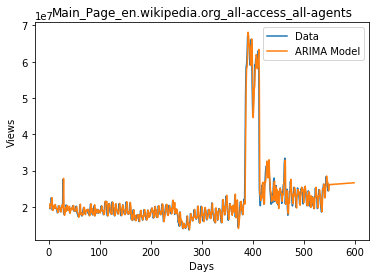

C:\Users\omistaja\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


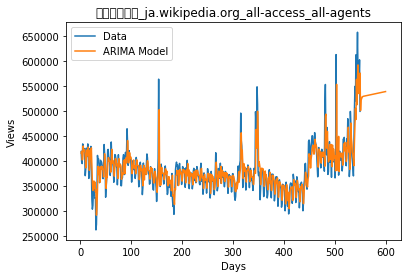

C:\Users\omistaja\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


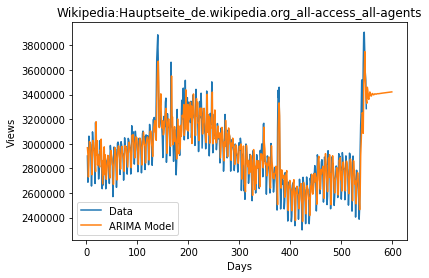

C:\Users\omistaja\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


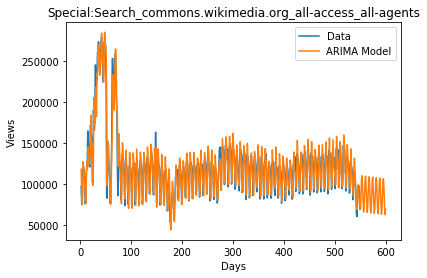

C:\Users\omistaja\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


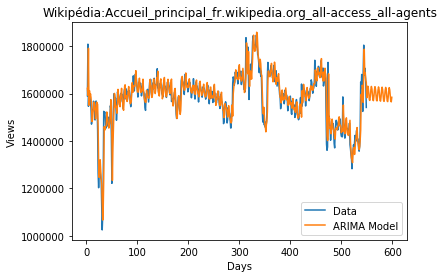

C:\Users\omistaja\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


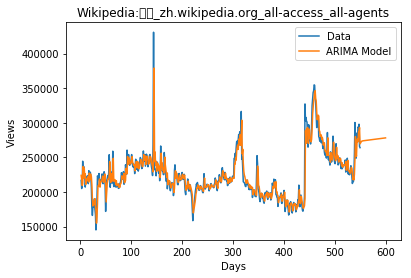

C:\Users\omistaja\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


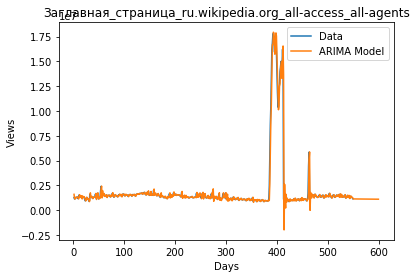

C:\Users\omistaja\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


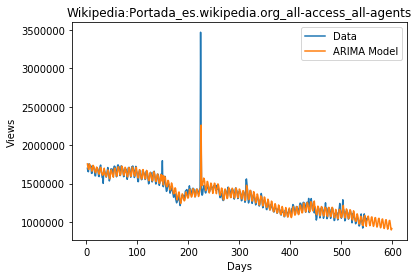

In [49]:
from statsmodels.tsa.arima_model import ARIMA
import warnings

cols = train.columns[1:-1]
for key in top_pages:
    data = np.array(train.loc[top_pages[key],cols],'f')
    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(data,[2,1,4])
            result = arima.fit(disp=False)
        except:
            try:
                arima = ARIMA(data,[2,1,2])
                result = arima.fit(disp=False)
            except:
                print(train.loc[top_pages[key],'Page'])
                print('\tARIMA failed')
    #print(result.params)
    pred = result.predict(2,599,typ='levels')
    x = [i for i in range(600)]
    i=0

    plt.plot(x[2:len(data)],data[2:] ,label='Data')
    plt.plot(x[2:],pred,label='ARIMA Model')
    plt.title(train.loc[top_pages[key],'Page'])
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()

We see that the ARIMA model in some cases is able to predict the weekly substructure of the signal, which is good. In other cases it seems to just give a linear fit. This is potentially very useful.

However, if we just blindly apply the ARIMA model to the whole dataset, the results are not nearly as good as just using a basic median model.

In [50]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means['weekday'] = times_series_means['date'].apply(lambda x: x.weekday())
times_series_means['Date_str'] = times_series_means['date'].apply(lambda x: str(x))
times_series_means[['year','month','day']] = pd.DataFrame(times_series_means['Date_str'].str.split('-',2).tolist(), columns = ['year','month','day'])
date_staging = pd.DataFrame(times_series_means['day'].str.split(' ',2).tolist(), columns = ['day','other'])
times_series_means['day'] = date_staging['day']*1
times_series_means.drop('Date_str',axis = 1, inplace =True)
times_series_means.head()


,date,Visits,weekday,year,month,day
0,2016-11-12,1491.626266,5,2016,11,12
1,2016-11-13,1625.662602,6,2016,11,13
2,2016-11-14,1650.061015,0,2016,11,14
3,2016-11-15,1514.151238,1,2016,11,15
4,2016-11-16,1473.522090,2,2016,11,16


In [51]:
times_series_means.reset_index(drop=True,inplace=True)

def lag_func(data,lag):
    lag = lag
    X = lagmat(data["diff"], lag)
    lagged = data.copy()
    for c in range(1,lag+1):
        lagged["lag%d" % c] = X[:, c-1]
    return lagged

def diff_creation(data):
    data["diff"] = np.nan
    data.ix[1:, "diff"] = (data.iloc[1:, 1].as_matrix() - data.iloc[:len(data)-1, 1].as_matrix())
    return data

df_count = diff_creation(times_series_means)

# Creation of 7 features with "diff"
lag = 7
lagged = lag_func(df_count,lag)
last_date = lagged['date'].max()
lagged.head()

C:\Users\omistaja\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


,date,Visits,weekday,year,month,day,diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,2016-11-12,1491.626266,5,2016,11,12,NaN,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,2016-11-13,1625.662602,6,2016,11,13,134.036336,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2016-11-14,1650.061015,0,2016,11,14,24.398413,134.036336,NaN,0.000000,0.0,0.0,0.0,0.0
3,2016-11-15,1514.151238,1,2016,11,15,-135.909777,24.398413,134.036336,NaN,0.0,0.0,0.0,0.0
4,2016-11-16,1473.522090,2,2016,11,16,-40.629147,-135.909777,24.398413,134.036336,NaN,0.0,0.0,0.0


In [52]:
# Train Test split
def train_test(data_lag):
    xc = ["lag%d" % i for i in range(1,lag+1)] + ['weekday'] + ['day']
    split = 0.70
    xt = data_lag[(lag+1):][xc]
    yt = data_lag[(lag+1):]["diff"]
    isplit = int(len(xt) * split)
    x_train, y_train, x_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]
    return x_train, y_train, x_test, y_test, xt, yt

x_train, y_train, x_test, y_test, xt, yt = train_test(lagged)

In [53]:
# Linear Model
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def modelisation(x_tr, y_tr, x_ts, y_ts, xt, yt, model0, model1):
    # Modelisation with all product
    model0.fit(x_tr, y_tr)

    prediction = model0.predict(x_ts)
    r2 = r2_score(y_ts.as_matrix(), model0.predict(x_ts))
    mae = mean_absolute_error(y_ts.as_matrix(), model0.predict(x_ts))
    print ("-----------------------------------------------")
    print ("mae with 70% of the data to train:", mae)
    print ("-----------------------------------------------")

    # Model with all data
    model1.fit(xt, yt) 
    
    return model1, prediction, model0

model0 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)
model1 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

clr, prediction, clr0  = modelisation(x_train, y_train, x_test, y_test, xt, yt, model0, model1)

-----------------------------------------------
mae with 70% of the data to train: 72.62445219777501
-----------------------------------------------


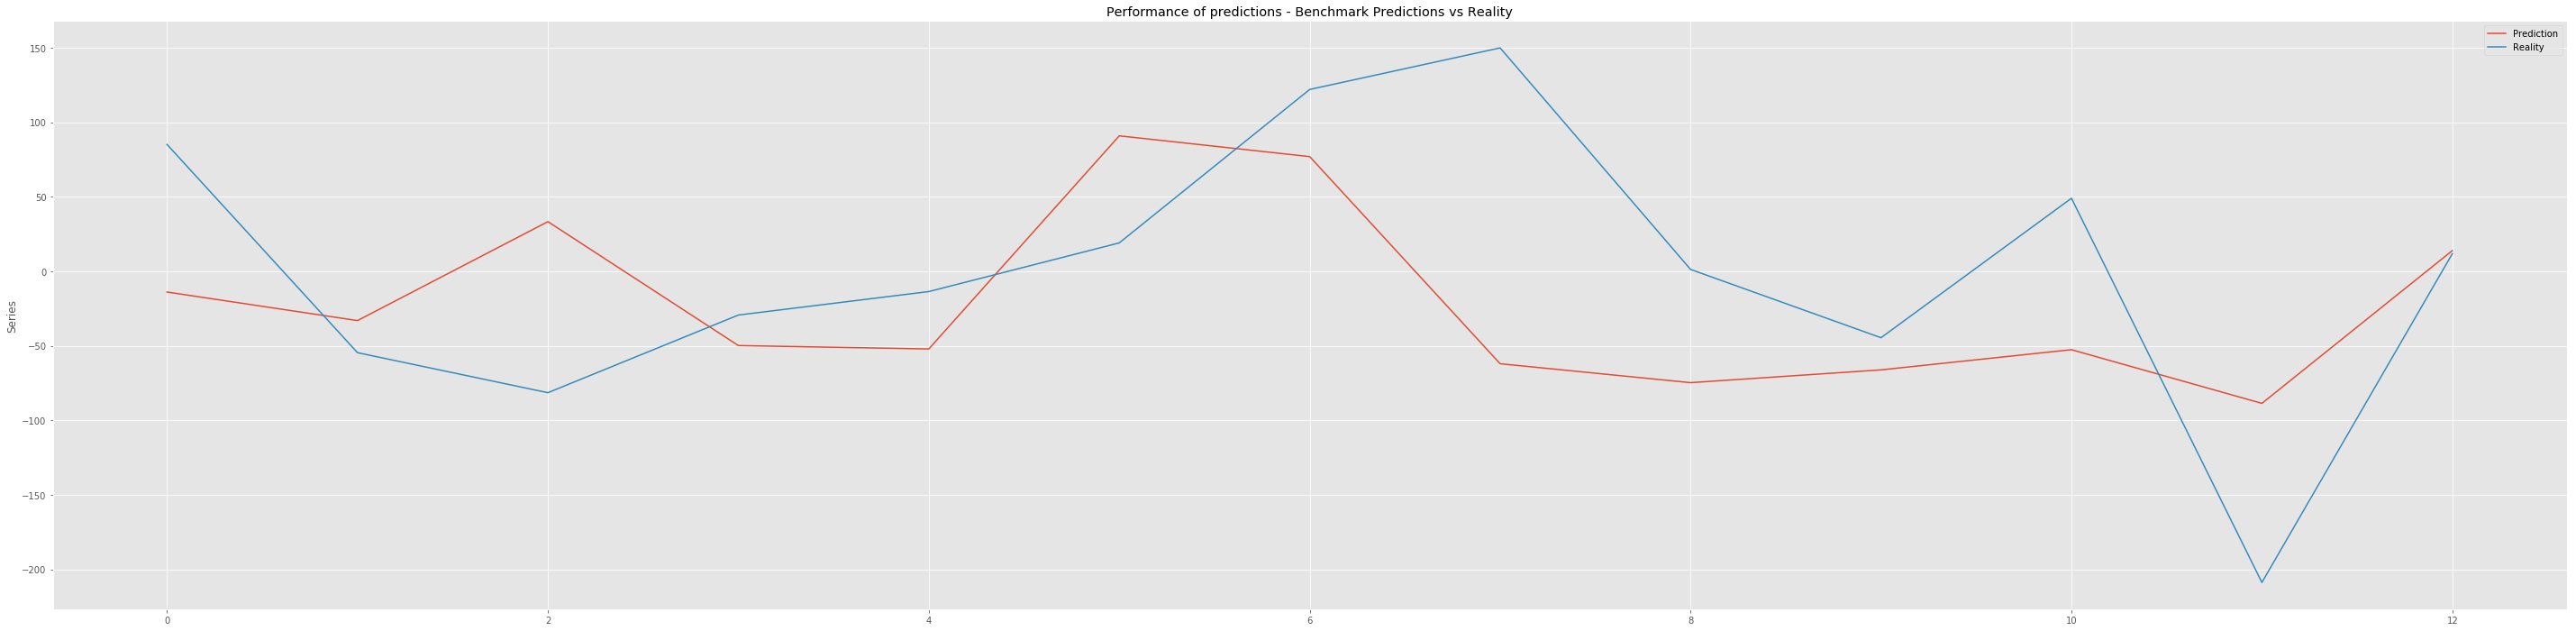

In [54]:
# Performance 1
plt.style.use('ggplot')
plt.figure(figsize=(50, 12))
line_up, = plt.plot(prediction,label='Prediction')
line_down, = plt.plot(np.array(y_test),label='Reality')
plt.ylabel('Series')
plt.legend(handles=[line_up, line_down])
plt.title('Performance of predictions - Benchmark Predictions vs Reality')
plt.show()

In [55]:
# Prediction
def pred_df(data,number_of_days):
    data_pred = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=1)),columns = ["date"])
    for i in range(number_of_days):
        inter = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=i+2)),columns = ["date"])
        data_pred = pd.concat([data_pred,inter]).reset_index(drop=True)
    return data_pred

data_to_pred = pred_df(df_count,30)

In [56]:
def initialisation(data_lag, data_pred, model, xtrain, ytrain, number_of_days):
    # Initialisation
    model.fit(xtrain, ytrain)
    
    for i in range(number_of_days-1):
        lag1 = data_lag.tail(1)["diff"].values[0]
        lag2 = data_lag.tail(1)["lag1"].values[0]
        lag3 = data_lag.tail(1)["lag2"].values[0]
        lag4 = data_lag.tail(1)["lag3"].values[0]
        lag5 = data_lag.tail(1)["lag4"].values[0]
        lag6 = data_lag.tail(1)["lag5"].values[0]
        lag7 = data_lag.tail(1)["lag6"].values[0]
        lag8 = data_lag.tail(1)["lag7"].values[0]
        
        data_pred['weekday'] = data_pred['date'].apply(lambda x:x.weekday())
        weekday = data_pred['weekday'][0]
        
        row = pd.Series([lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,weekday]
                        ,['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        to_predict = pd.DataFrame(columns = ['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        prediction = pd.DataFrame(columns = ['diff'])
        to_predict = to_predict.append([row])
        prediction = pd.DataFrame(model.predict(to_predict),columns = ['diff'])

        # Loop
        if i == 0:
            last_predict = data_lag["Visits"][data_lag.shape[0]-1] + prediction.values[0][0]

        if i > 0 :
            last_predict = data_lag["Visits"][data_lag.shape[0]-1] + prediction.values[0][0]
        
        data_lag = pd.concat([data_lag,prediction.join(data_pred["date"]).join(to_predict)]).reset_index(drop=True)
        data_lag["Visits"][data_lag.shape[0]-1] = last_predict
        
        # test
        data_pred = data_pred[data_pred["date"]>data_pred["date"][0]].reset_index(drop=True)
        
    return data_lag

model_fin = AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

In [57]:
lagged = initialisation(lagged, data_to_pred, model_fin, xt, yt, 30)
lagged[lagged['diff']<0]
lagged.ix[(lagged.Visits < 0), 'Visits'] = 0

C:\Users\omistaja\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\omistaja\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


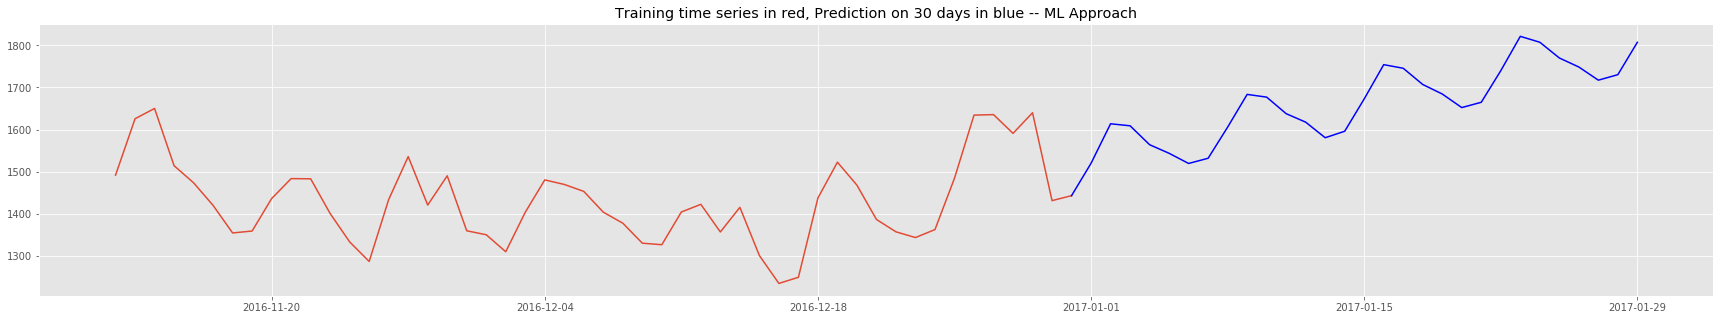

In [58]:
df_lagged = lagged[['Visits','date']]
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits)
plt.plot(df_pred.date,df_pred.Visits,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()
    

In [59]:
lagged_basic = lagged[['date','Visits','weekday']]
lagged_basic_tr   = lagged_basic[lagged_basic['date'] < last_date]
lagged_basic_pred = lagged_basic[lagged_basic['date'] >= last_date]
lagged_basic_pred.drop('Visits',inplace=True,axis=1)

prediction_by_days = pd.DataFrame(lagged_basic.groupby(['weekday'])['Visits'].mean())
prediction_by_days.reset_index(drop=False,inplace=True)
prediction_by_days

C:\Users\omistaja\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,weekday,Visits
0,0.0,1588.674580
1,1.0,1567.197432
2,2.0,1518.954885
3,3.0,1488.400445
4,4.0,1432.674641
5,5.0,1465.982336
6,6.0,1562.440619


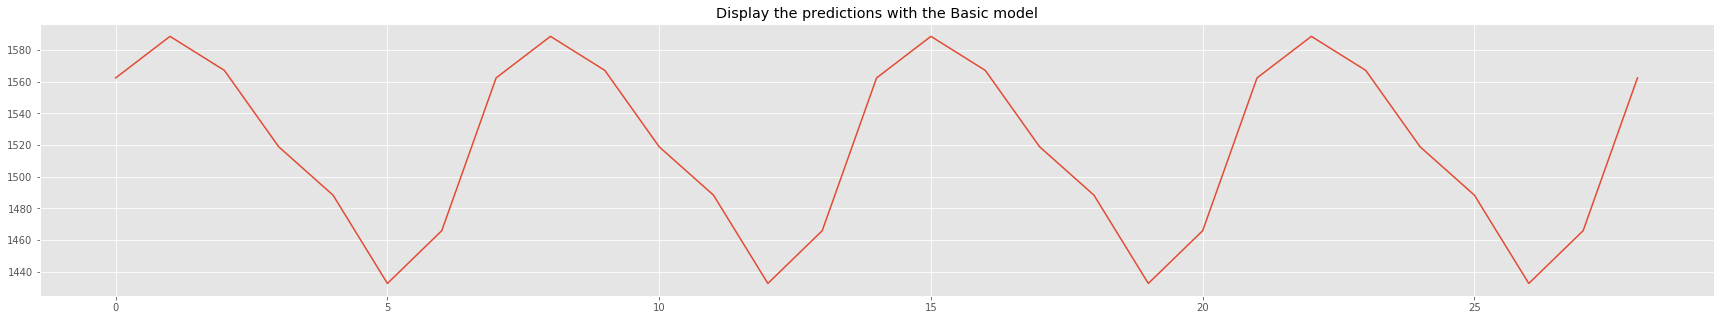

In [60]:
basic_pred = pd.merge(lagged_basic_pred,prediction_by_days,on='weekday')
basic_approach = pd.concat([lagged_basic_tr,basic_pred])

plot_basic = np.array(basic_approach[basic_approach['date'] > last_date].sort_values(by='date').Visits)

plt.figure(figsize=(30, 5))
plt.plot(plot_basic)
plt.title('Display the predictions with the Basic model')
plt.show()

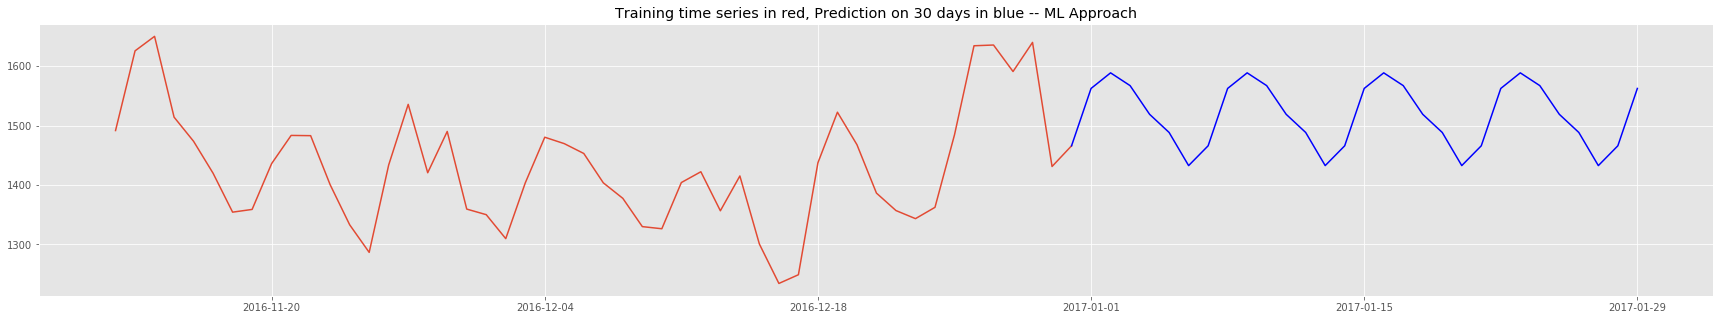

In [61]:
df_lagged = basic_approach[['Visits','date']].sort_values(by='date')
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits)
plt.plot(df_pred.date,df_pred.Visits,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()
    